# Pruebas con Albumentations

In [214]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
import albumentations as A
from PIL import Image
import matplotlib.patches as patches


In [216]:
import pickle
with open("data.pkl","rb") as f:
    (df_train, df_val, train_files, classes_idx, cant_classes, classes) = pickle.load(f)

In [217]:
with open("anchor_boxes.pkl", "rb") as f:
    anchor_boxes = pickle.load(f)
cant_anchor_boxes = len(anchor_boxes)
print(cant_anchor_boxes)

4


In [218]:
transform = A.Compose([
    A.RandomCrop(width=300, height=300),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='coco', min_area=300, min_visibility=0.1, label_fields=["class_labels"]))

In [219]:
df_train.loc[0]

,label,left,top,right,bottom,height,width,image,image_name,center_x,center_y,delta_x,delta_y
0,pineapple,38.0,82.0,271.0,227.0,300.0,400.0,dataset\images\fruit0.png,fruit0.png,154.5,154.5,233.0,145.0
0,pineapple,38.0,87.0,275.0,241.0,300.0,400.0,dataset\images\fruit1.png,fruit1.png,156.5,164.0,237.0,154.0
0,pineapple,92.0,116.0,259.0,215.0,300.0,400.0,dataset\images\fruit10.png,fruit10.png,175.5,165.5,167.0,99.0
0,pineapple,37.0,47.0,225.0,165.0,300.0,400.0,dataset\images\fruit100.png,fruit100.png,131.0,106.0,188.0,118.0
0,pineapple,38.0,64.0,223.0,175.0,300.0,400.0,dataset\images\fruit101.png,fruit101.png,130.5,119.5,185.0,111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,pineapple,136.0,47.0,262.0,155.0,300.0,400.0,dataset\images\fruit94.png,fruit94.png,199.0,101.0,126.0,108.0
0,pineapple,150.0,76.0,262.0,171.0,300.0,400.0,dataset\images\fruit95.png,fruit95.png,206.0,123.5,112.0,95.0
0,pineapple,140.0,60.0,259.0,163.0,300.0,400.0,dataset\images\fruit96.png,fruit96.png,199.5,111.5,119.0,103.0
0,pineapple,149.0,80.0,250.0,170.0,300.0,400.0,dataset\images\fruit97.png,fruit97.png,199.5,125.0,101.0,90.0


In [220]:
img_nbr=9 # 10 anda
image_name = train_files[img_nbr].stem + ".png"
image_file = df_train[df_train["image_name"] == image_name]["image"]

In [221]:
print(image_name)

fruit106.png


In [222]:
image_name

'fruit106.png'

In [223]:
image_file

0    dataset\images\fruit106.png
1    dataset\images\fruit106.png
2    dataset\images\fruit106.png
Name: image, dtype: object

In [224]:
image = np.array(Image.open(image_file.values[0]))
bboxes = df_train[df_train["image"]==image_file.values[0]][["left","top","delta_x","delta_y"]]

In [225]:
labels = df_train[df_train["image"]==image_file.values[0]]["label"]

In [226]:
print(labels.values)

['pineapple' 'snake fruit' 'banana']


In [227]:
bboxes

,left,top,delta_x,delta_y
0,61.0,105.0,162.0,99.0
1,205.0,219.0,32.0,21.0
2,274.0,134.0,51.0,58.0


In [228]:
bboxes.values

array([[ 61., 105., 162.,  99.],
       [205., 219.,  32.,  21.],
       [274., 134.,  51.,  58.]])

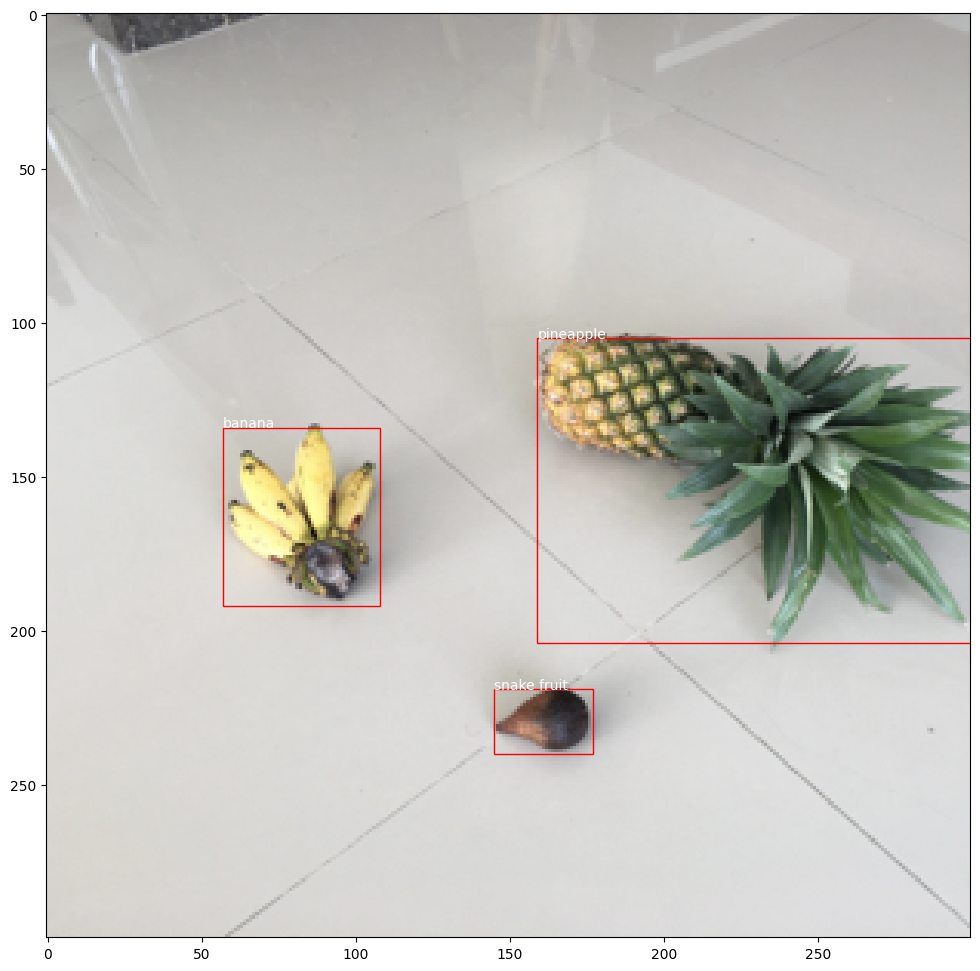

In [229]:
transformed = transform(image=image, bboxes=bboxes.values, class_labels = labels)
# Create figure and axes
fig,ax = plt.subplots(1, figsize=[12,12])
plt.imshow(transformed["image"])
for i in range(len(transformed["bboxes"])):
    bbox = transformed["bboxes"][i]
    rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.text(bbox[0],bbox[1], labels[i], c="w")
plt.show()

In [230]:
bboxes_aug = transformed["bboxes"]
image_aug = transformed["image"]

# En qué gridcell anoto cada bbox?

supongamos gridcells de 32x32

Esta celda indica en qué gridcell se encuentra el centro del bounding box.

In [231]:
# Es útil tener una función que reciba los bounding boxes y me devuelva en qué gridcell debo anotar cada uno
def get_gridcell(bboxes_aug, grid_size):
    print( [((bbox[0] + bbox[2]/2), 
             (bbox[1] + bbox[3]/2)) for bbox in bboxes_aug])
    grid_cells = [((bbox[0] + bbox[2]/2)//grid_size[0], 
                   (bbox[1] + bbox[3]/2)//grid_size[1]) for bbox in bboxes_aug]
    return grid_cells

In [232]:
bboxes_aug

array([[159.      , 105.      , 141.      ,  99.00001 ],
       [145.00002 , 219.      ,  31.999992,  20.999998],
       [ 57.      , 134.      ,  51.      ,  58.      ]], dtype=float32)

In [233]:
get_gridcell(bboxes_aug,[32,32])

[(229.5, 154.50000381469727), (161.0000114440918, 229.49999904632568), (82.5, 163.0)]


[(7.0, 4.0), (5.0, 7.0), (2.0, 5.0)]

In [234]:
# Es exactamente la misma función que antes, pero sin los prints
def get_gridcell(bboxes_aug,grid_size):
    grid_cells = [(int((bbox[0] + bbox[2]/2)//grid_size[0]), 
                   int((bbox[1] + bbox[3]/2)//grid_size[1])) for bbox in bboxes_aug]
    return grid_cells

In [235]:
grid_cells = get_gridcell(bboxes_aug,[32,32]) # grid_cells a los que pertenecen los bounding boxes
grid_cells_u = np.unique(get_gridcell(bboxes_aug,[32,32]),axis=1) #uniques de los grid_cells, esto es por si varios van al mismo gridcell

In [236]:
grid_cells

[(7, 4), (5, 7), (2, 5)]

# Chequeo de IoU con anchor boxes

In [237]:
# Esta función me devuelve el IoU entre un bounding box y cada uno de los anchor boxes para luego decidir en cuáles lo anoto
def anchor_check(anchor_boxes, bbox):
    aux_bbox = np.array(bbox).reshape(-1,4).repeat(len(anchor_boxes),axis=0)
    # Compara ancho_anchor_box vs deltax (minimo) * alto_anchor_box vs deltay (minimo)
    intersects = np.min([anchor_boxes[:,0],aux_bbox[:,2]],axis=0)*np.min([anchor_boxes[:,1],aux_bbox[:,3]],axis=0)
    union = aux_bbox[:,2]*aux_bbox[:,3]+anchor_boxes[:,0]*anchor_boxes[:,1]-intersects
    return intersects/union

In [238]:
# Defino el umbral a partir del cual anoto un bounding box en un anchor box
IoU_alpha = 0.5

img_nbr=10

In [239]:
annotations = list()
for cell_u in grid_cells_u:
    indexes = [cell_u.tolist() == list(grid_cell) for grid_cell in grid_cells]
    bboxes_cell = [bboxes_aug[idx] for idx,index in enumerate(indexes) if index]
    winners = np.zeros([len(bboxes_cell),len(anchor_boxes)])
    for idx,bbox in enumerate(bboxes_cell):
        winners[idx,:] = anchor_check(anchor_boxes,bbox)
    mask = winners.max(axis=0) > IoU_alpha
    bbox_nbr = winners.argmax(axis=0)
    for ab,(m,b) in enumerate(zip(mask,bbox_nbr)):
        if m:
            annotations.append((*cell_u, ab, *bboxes_cell[b]))

ValueError: zero-size array to reduction operation maximum which has no identity

In [210]:
# grid_cell_x, grid_cell_y, anchor_box, min_x, min_y, delta_x, delta_y, clase
annotations[0]

(2, 4, 0, 0.0, 99.00001, 160.0, 100.0)

# Conversión del formato de la anotación a YOLO

In [211]:
ann_size = 1 + cant_classes + 4 # confidencia + clase + bbox
y = np.zeros([1,int(512/32),int(512/32),len(anchor_boxes)*ann_size]) #reservo espacio para las anotaciones de 1 imagen

In [212]:
y.shape

(1, 16, 16, 36)

In [213]:
# grid_cell, anchor_box, bbox
for ann in annotations:
    y[0,ann[1],ann[0], ann[2]*ann_size] = 1 # Anoto que hay objeto en este AB
    y[0,ann[1],ann[0], ann[2]*ann_size+1+classes_idx[ann[7]]] = 1 # Anoto la clase del objeto
    y[0,ann[1],ann[0], ann[2]*ann_size+1+cant_classes:ann[2]*ann_size+1+cant_classes+4] = ann[3:7]

IndexError: tuple index out of range

In [44]:
annotations[1]

(3,
 11,
 2,
 0.0,
 213.90722300000016,
 229.08000000000004,
 278.06910700000003,
 'Tomato')

In [46]:
y[0,11,3].reshape(-1,ann_size)

array([[  1.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   1.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
        213.907223, 229.08    , 278.069107],
       [  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ],
       [  1.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   1.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
        213.907223, 229.08    , 278.069107],
       [  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ],
    

# No nos sirve el formato del bbox para YOLO, tenemos que referirlo a la celda


center_x,center_y: 0,0 -> borde superior izquierdo de la celda  
x,y: 1,1 -> borde inferior derecho de la celda  
delta_x y delta_y: 1 para indicar un gridcell de ancho, puede ser mayor a 1  

In [100]:
anns = np.array(annotations)
anns = anns[:,:-1].astype(float)

In [101]:
anns[0]

array([  3.      ,  11.      ,   0.      ,   0.      , 213.907223,
       229.08    , 278.069107])

In [102]:
anns[:,3] = ((anns[:,3]+anns[:,5]/2)-anns[:,0]*32)/32
anns[:,4] = ((anns[:,4]+anns[:,6]/2)-anns[:,1]*32)/32

In [103]:
anns[0]

array([3.00000000e+00, 1.10000000e+01, 0.00000000e+00, 5.79375000e-01,
       2.94305156e-02, 2.29080000e+02, 2.78069107e+02])

In [104]:
213.9+278.07/2

352.935

In [105]:
anns = np.array(annotations)
anns = anns[:,:-1].astype(float)
anns[:,3:5] = ((anns[:,3:5]+anns[:,5:7]/2)-anns[:,0:2]*32)/32
anns[0]

array([3.00000000e+00, 1.10000000e+01, 0.00000000e+00, 5.79375000e-01,
       2.94305156e-02, 2.29080000e+02, 2.78069107e+02])